In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [2]:
import multiprocessing as mp
import functools

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [4]:
import wispy.lalutils
import wispy.model_utils
import wispy.callbacks

In [5]:
import lalsimulation as lalsim

# try a 2D parameter space

In [6]:
# training set - 2D regular grid
# validation set - random/regular

In [7]:
def make_training_set_2d_q_s1x(qmin=1, qmax=2, npts_q=5, s1xmin=0, s1xmax=0.99, npts_s1x=5):
    q_1d = np.linspace(qmin, qmax, npts_q)
    s1x_1d = np.linspace(s1xmin, s1xmax, npts_s1x)
    X, Y = np.meshgrid(q_1d, s1x_1d)
    return X.ravel(), Y.ravel()

In [8]:
# q_arr, s1x_arr = make_training_set_2d_q_s1x(npts_q=20, npts_s1x=20)
q_arr, s1x_arr = make_training_set_2d_q_s1x(npts_q=6, npts_s1x=6)

dx = (q_arr[1]-q_arr[0])/2
dy = (s1x_arr[1]-s1x_arr[0])/2

q_arr_val, s1x_arr_val = make_training_set_2d_q_s1x(qmin=q_arr[0]+dx, qmax=q_arr[-1]-dx, npts_q=5, s1xmin=s1x_arr[0]+dy, s1xmax=s1x_arr[-1]-dy, npts_s1x=6)

In [9]:
q_arr.shape

(36,)

In [10]:
q_arr_val.shape

(30,)

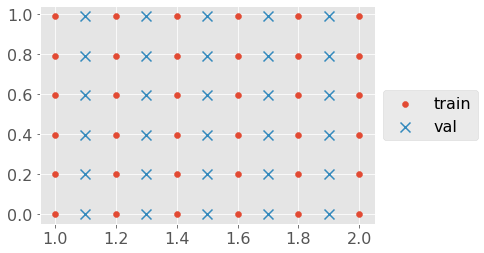

In [11]:
plt.figure()
plt.scatter(q_arr, s1x_arr, label='train')
plt.scatter(q_arr_val, s1x_arr_val, marker='x', s=100, label='val')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
def gen_data_2d_q_s1x(q_arr, s1x_arr, M=100, nproc=1):

    ps = []
    for q, s1x in zip(q_arr, s1x_arr):
        m1, m2 = phenom.m1_m2_M_q(M, q)
        ps.append(wispy.lalutils.gen_td_wf_params(m1=m1, m2=m2, S1x=s1x, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6))
    
    times = []
    amp = []
    phase = []

#     for p in ps:
#         _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
#         times.append(_times)
#         amp.append(_amp)
#         phase.append(_phase)    
    
#     def mapable(p):
#         _times, _amp, _phase = wispy.lalutils.gen_td_wf(p, t_max=40)
#         return (_times, _amp, _phase)
    
    func = functools.partial(wispy.lalutils.gen_td_wf, t_max=40)
    
    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)
#     print(len(returned))
#     print(len(returned[0]))
#     print(returned[0])
    for i in range(len(returned)):
        times.append(returned[i][0])
        amp.append(returned[i][1])
        phase.append(returned[i][2])   


        
    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt_M)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")
    
    n_cases = len(ps)

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)
        
    X = np.column_stack((q_arr, s1x_arr))
        
    return common_times, amps, phases, X

In [13]:
%%time
common_times, amps, phases, X = gen_data_2d_q_s1x(q_arr=q_arr, s1x_arr=s1x_arr, M=100, nproc=4)

common_tmin = -499.518772035577
common_tmax = 39.52014281228902
ntimes = 1079
CPU times: user 41.3 ms, sys: 23.4 ms, total: 64.8 ms
Wall time: 25.1 s


In [14]:
%%time
_, amps_val, phases_val, X_val = gen_data_2d_q_s1x(q_arr=q_arr_val, s1x_arr=s1x_arr_val, M=100, nproc=4)

common_tmin = -499.5324541740016
common_tmax = 39.50843560386919
ntimes = 1079
CPU times: user 35.8 ms, sys: 19.6 ms, total: 55.4 ms
Wall time: 21.7 s


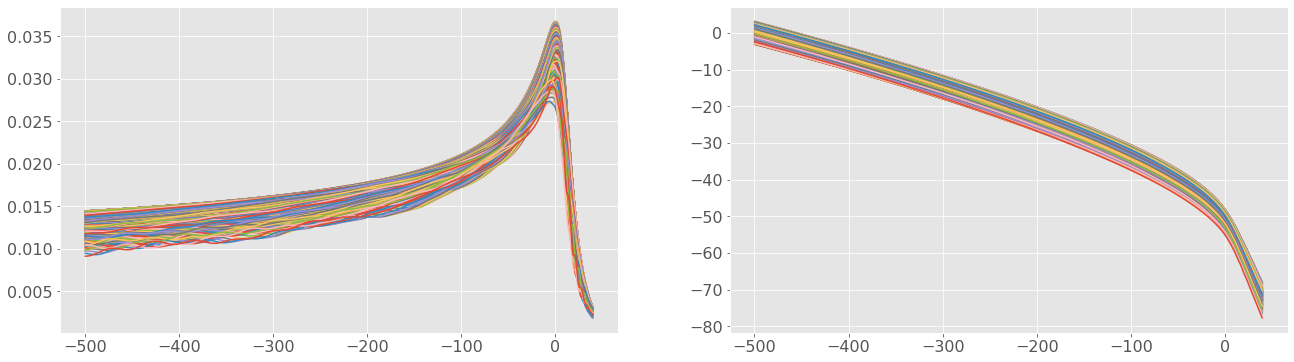

In [554]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for y in amps:
    plt.plot(common_times, y)
    
# plt.xlim(-100, 40)


plt.subplot(1, 2, 2)
for y in phases:
    plt.plot(common_times, y)

In [555]:
y = amps.copy()
# y = phases.copy()
# y = np.array([yy-yy[0] for yy in y])
ymean = np.mean(y, axis=0)[np.newaxis, :]
y -= ymean
# y_max = np.max(np.abs(y))
y_max = np.max(y)
y /= y_max


yval = amps_val.copy()
yval -= ymean
yval /= y_max

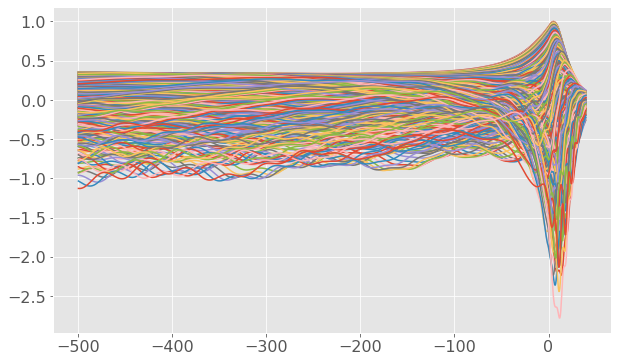

In [556]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for yy in y:
    plt.plot(common_times, yy)
    
# plt.xlim(-100, 40)

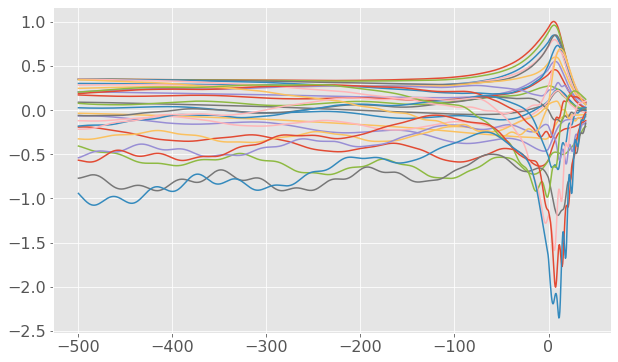

In [557]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for yy in yval:
    plt.plot(common_times, yy)
    
# plt.xlim(-100, 40)

In [558]:
# reverse processing
y2 = y.copy()
y2 *= y_max
y2 += ymean

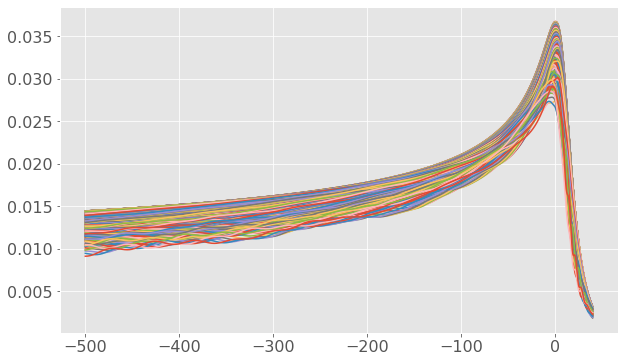

In [559]:
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
for yy in y2:
    plt.plot(common_times, yy)
    
# plt.xlim(-100, 40)

In [560]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [561]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)
    
    threshold_callback = wispy.callbacks.ThresholdCallback(1e-9)
    callbacks.append(threshold_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

In [605]:
model = build_decoder(input_shape=X.shape[1], output_shape=y.shape[1], units = [64, 1000], acts = ['relu', 'relu'])

In [606]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_40 (Dense)             (None, 1000)              65000     
_________________________________________________________________
dense_41 (Dense)             (None, 1079)              1080079   
Total params: 1,145,271
Trainable params: 1,145,271
Non-trainable params: 0
_________________________________________________________________


In [607]:
X.shape

(400, 2)

In [608]:
X_val.shape

(30, 2)

In [609]:
y.shape

(400, 1079)

In [610]:
yval.shape

(30, 1079)

Training:   0%|           0/100000 ETA: ?s,  ?epochs/s

CPU times: user 2h 42min 44s, sys: 6min 49s, total: 2h 49min 34s
Wall time: 33min 4s


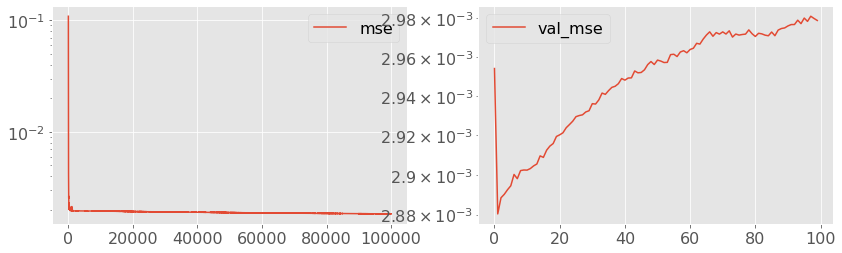

In [611]:
%%time
amp_history, model_amp = initial_fit(
    model,
    x=X,
    y=y,
    validation_data=(X_val, yval),
    epochs=100000,
    batch_size=100,
    validation_freq=1000,
    lr=None)

In [612]:
amp_history.history['mse'][-1]

0.0018368103774264455

In [613]:
def compare_models(model, x, y, index, times=common_times):
    
    y=y.copy()
    
    yhat = model.predict(x)
    
    # reverse processing
    yhat *= y_max
    yhat += ymean[0]
    yhat = yhat[index]
    

    y *= y_max
    y += ymean[0]
    y = y[index]

    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat', ls='--')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.xlim(-100, 20)
#     plt.ylim(-70, -40)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

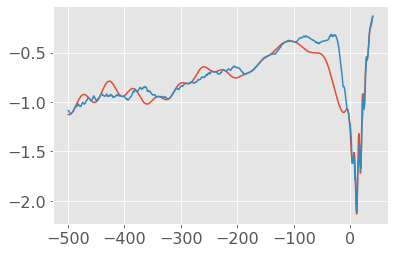

In [614]:
plt.figure()
plt.plot(common_times, y[-1])
plt.plot(common_times, model_amp.predict(X)[-1])

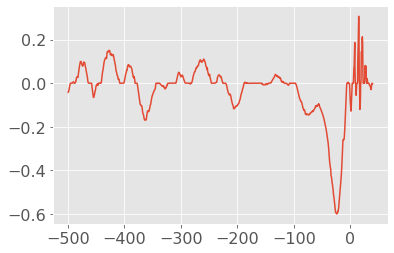

In [615]:
plt.figure()
plt.plot(common_times, y[-1]-model_amp.predict(X)[-1])

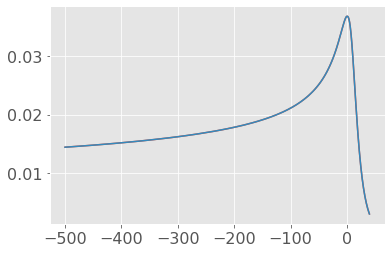

In [616]:
plt.figure()
plt.plot(common_times, (y[0]*y_max)+ymean[0])
plt.plot(common_times, (model_amp.predict(X)[0]*y_max)+ymean[0])

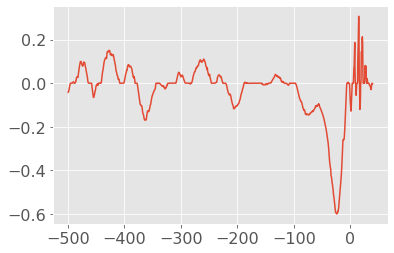

In [617]:
plt.figure()
plt.plot(common_times, y[-1]-model_amp.predict(X)[-1])

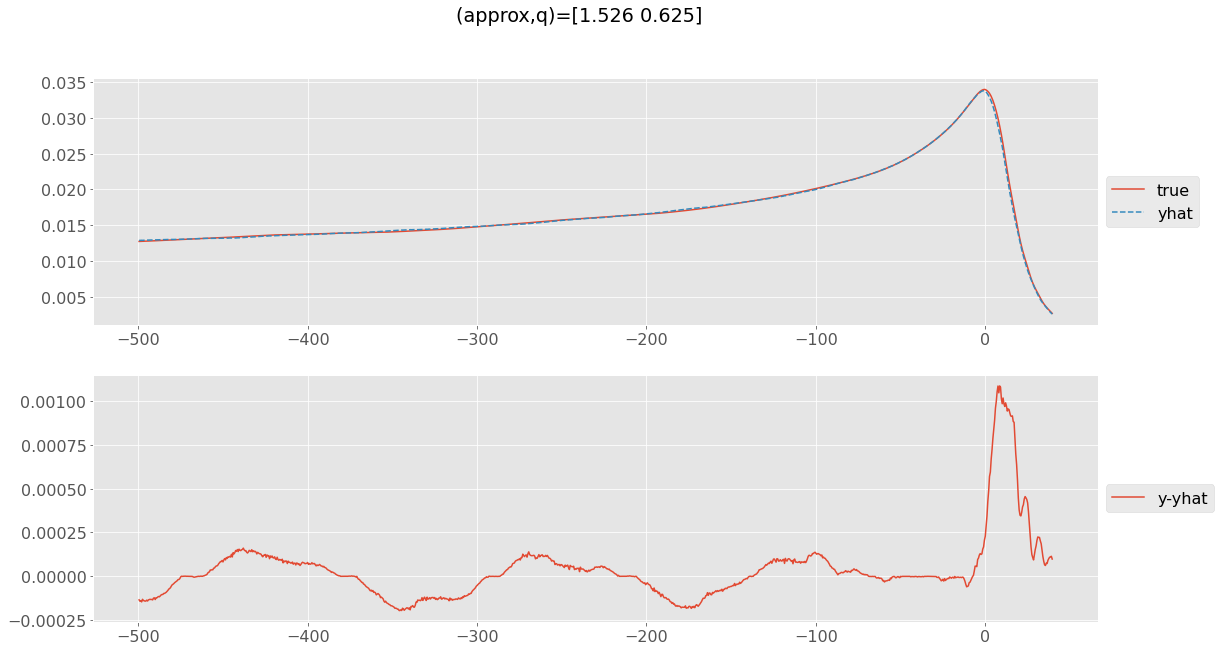

In [629]:
compare_models(model_amp, X, y, 250, common_times)

In [619]:
model_amp.evaluate(X, y)

13/13 [==============================] - 0s 2ms/step - loss: 0.0196 - mse: 0.0018    


[0.01961696520447731, 0.0018358529778197408]

In [620]:
model_amp.evaluate(X_val, yval)

1/1 [==============================] - 0s 17ms/step - loss: 0.0258 - mse: 0.0030


[0.025783928111195564, 0.002978793578222394]

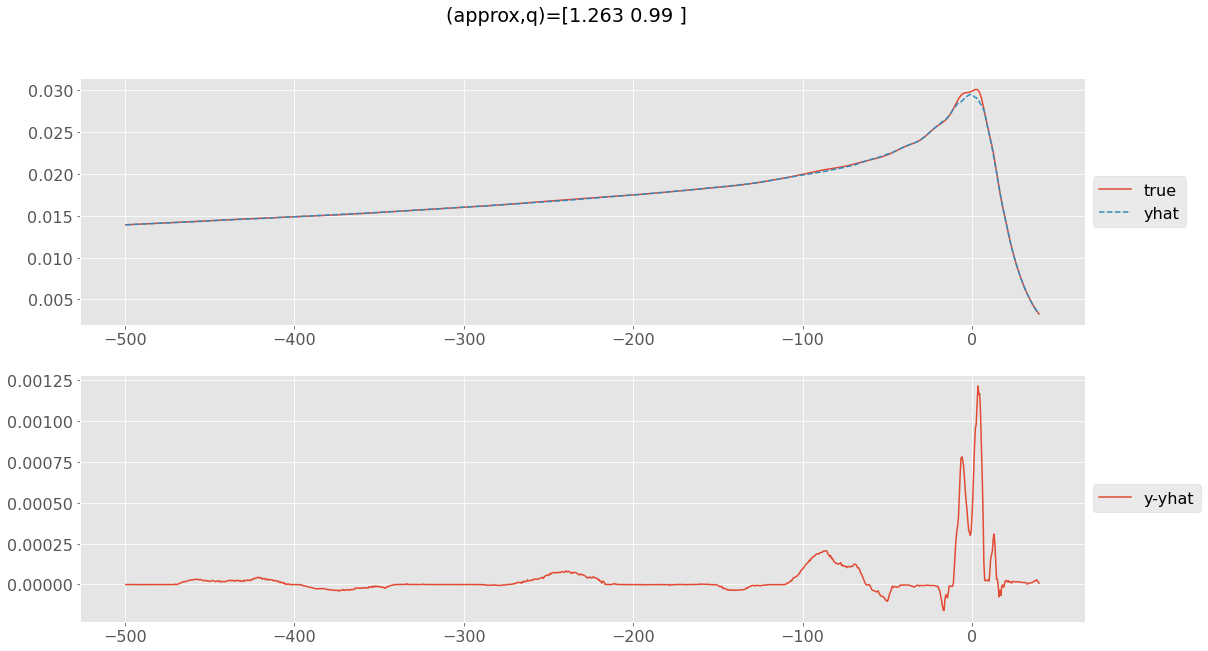

In [621]:
compare_models(model_amp, X_val, yval, -4, common_times)